# Simple example running PlutoSDR on Sionna

Replaces the channel simulation. Go make your over the air demonstrations with cheap DNN based radios!

Limitations: 
- batch size must be 1 
- SISO 1T1R only (2T2R possible later on)

Requires:
- libiio, Analog Device’s library for interfacing hardware
- libad9361-iio, AD9361 the Analog Devices RF chip
- pyadi-iio, Python API for PlutoSDR

## Note that transmitting anything requires appropriate license, failing to have a license will get you in trouble!!! 

### GPU Configuration and Imports 

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

2023-07-26 19:20:00.677688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 19:20:01.288939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of GPUs available : 1
Only GPU number 0 used.


2023-07-26 19:20:02.045543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 19:20:02.071337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 19:20:02.071476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pickle
import time

import sionna
from sionna.mimo import StreamManagement
from tensorflow.keras import Model

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils import BinarySource, ebnodb2no, sim_ber, PlotBER
from sionna.utils.metrics import compute_ber


### Stream Management <a class="anchor" id="Stream-Management"></a>

In [3]:
# Define the number of UT and BS antennas for SISO
num_ut = 1
num_bs = 1
num_ut_ant = 1
num_bs_ant = 1

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

### OFDM Resource Grid & Pilot Pattern <a class="anchor" id="OFDM-Resource-Grid-&-Pilot-Pattern"></a>

2023-07-26 19:20:02.648102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 19:20:02.648271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 19:20:02.648377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

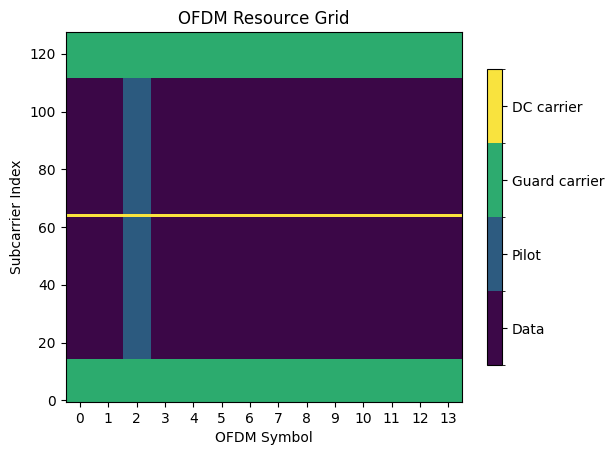

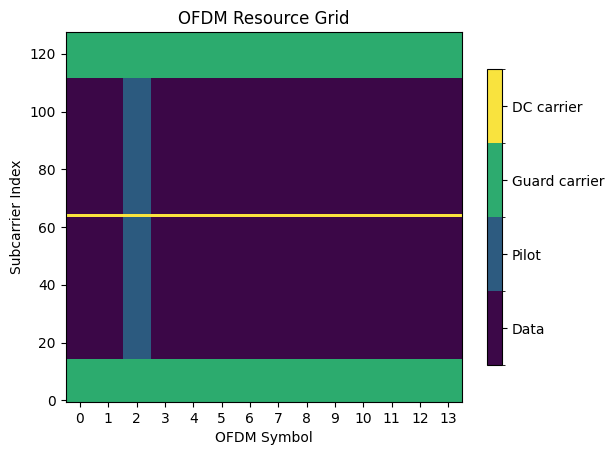

In [4]:
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=128,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=1,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[15,16],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2])
rg.show()

In [5]:
num_bits_per_symbol = 6 # QPSK modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, 0, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

### import PlutoSDR library for Sionna use

PlutoSDR parameters:
- SDR_TX_IP: IP address of the PlutoSDR
- SDR_TX_FREQ: Transmit frequency in Hz
- SDR_TX_BANDWIDTH: Transmit bandwidth in Hz
- SampleRate: Sample rate in Hz

In [6]:
import SDR_Sionna_1T1R as sdr

SampleRate = rg.fft_size*rg.subcarrier_spacing # sample rate

# Start the radio!!!! Careful here, radio transmissions are only allowed with appropriate licenses!!! (915-928 in NZ is radio amateur band, and I have license so I can transmit)
SDR1 = sdr.SDR(SDR_TX_IP="ip:192.168.3.1", SDR_TX_FREQ=921.1e6, SDR_TX_BANDWIDTH=SampleRate*1.1, SampleRate = SampleRate)


# Eager mode example with SDR 

### Single run in debug mode for SDR debug graphs

sdr.SDR input parameters:
- SAMPLES: symbols output from sionna modulator
- SDR_TX_GAIN: transmitter gain. 0dB is maximum
- add_td_samples: number of additional symbols to cater fordelay spread
- debug: True for pretty(-ish) graphs

sdr.SDR output parameters x_xdr (see below):
- x_sdr[0] : samples
- x_sdr[1] : SINR estimate
- x_sdr[2] : actual TX_Gain setting in SDR
- x_sdr[3] : actual RX_Gain setting in SDR
- x_sdr[4] : Attempts - the algorithm tries to send again with increased power if correlation is not found
- x_sdr[5] : Pearson R - the correlation between transmitted and received signals
- x_sdr[6] : SDR time - how long it took to input the samples, transmit, receive, and output the samples. Typically ~23ms in my test set up, around 1sec if debug=True and graphs are created.

/home/riku/projects/sionna/test/SDR_Sionna_1T1R.py:164: RuntimeWarning: divide by zero encountered in log10
  axs[0,0].plot(10*np.log10(abs(rx_samples)/max(abs(rx_samples))), label='RX_dB')


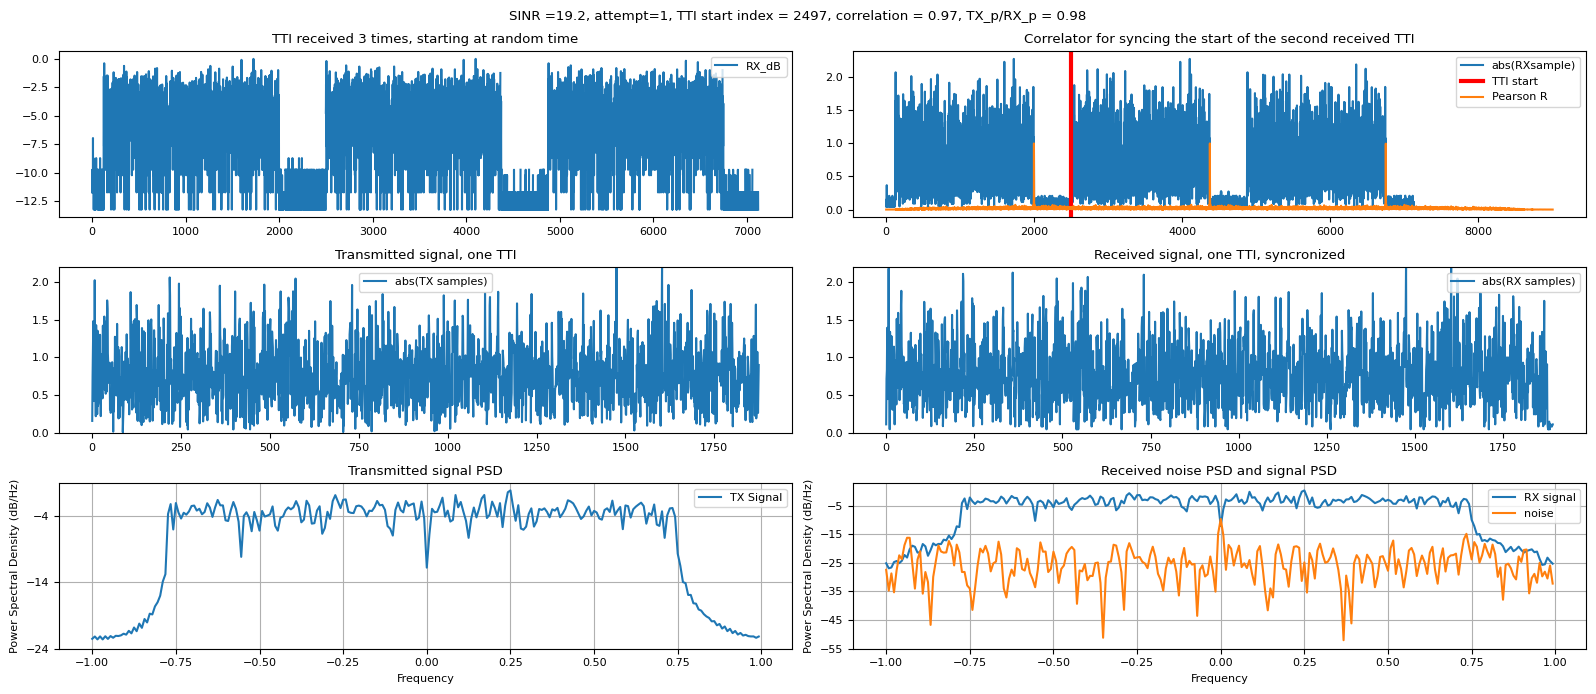

2023-07-26 19:20:06.774531: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x815d450


BER: 0.000, TX_Gain: -10dB, RX_Gain: 10dB, Attempts: 1, Pearson R: 0.97, SINR 19.2dB, SDR time: 933ms


In [7]:
batch_size = 1 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)
# outputs: received symbols in tf Sionna compatible format, 
# SINR, SDR_TX_GAIN, SDR_RX_GAIN, Attempts, Pearson R
x_sdr = SDR1(SAMPLES = x_time, SDR_TX_GAIN=-10, SDR_RX_GAIN = 10, add_td_samples = 16, debug=True) # transmit
########################################################################################################################################################
y = demodulator(x_sdr[0]) # received samples in tf Sionna compatible format

no = ebnodb2no((x_sdr[1]), num_bits_per_symbol, coderate, rg) # SINR estimate
h_hat, err_var = ls_est ([y, no]) 

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)

print(f"BER: {ber:1.3f}, TX_Gain: {x_sdr[2]}dB, RX_Gain: {x_sdr[3]}dB, Attempts: {x_sdr[4]}, Pearson R: {x_sdr[5]:1.2f}, SINR {x_sdr[1]:1.1f}dB, SDR time: {x_sdr[6]*1000:1.0f}ms")

### Multiple runs with various TX power setting

In [8]:
for SDR_TX_GAIN in range(-10,-35,-2):
    
    batch_size = 1 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
    b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)

    # OFDM modulation with cyclic prefix insertion
    x_time = modulator(x_rg)
    
    ########################################################################################################################################################
    x_sdr = SDR1(SAMPLES = x_time, SDR_TX_GAIN=SDR_TX_GAIN, SDR_RX_GAIN = 20, add_td_samples = 16, debug=False)
    ########################################################################################################################################################

    # OFDM demodulation and cyclic prefix removal
    y = demodulator(x_sdr[0])

    no = ebnodb2no((x_sdr[1]), num_bits_per_symbol, coderate, rg)
    h_hat, err_var = ls_est ([y, no])

    x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
    llr = demapper([x_hat, no_eff])
    b_hat = decoder(llr)
    ber = compute_ber(b, b_hat)
    
    print(f"BER: {ber*100:1.1f}%, TX_Gain: {x_sdr[2]}dB, RX_Gain: {x_sdr[3]}dB, Attempts: {x_sdr[4]}, Pearson R: {x_sdr[5]:1.2f}, SINR {x_sdr[1]:1.1f}dB, SDR time: {x_sdr[6]*1000:1.0f}ms")

BER: 0.0%, TX_Gain: -10dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.98, SINR 25.6dB, SDR time: 31ms
BER: 0.0%, TX_Gain: -12dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.98, SINR 22.8dB, SDR time: 28ms
BER: 0.0%, TX_Gain: -14dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.98, SINR 20.5dB, SDR time: 27ms
BER: 0.0%, TX_Gain: -16dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.98, SINR 19.5dB, SDR time: 28ms
BER: 0.0%, TX_Gain: -18dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.96, SINR 15.7dB, SDR time: 27ms
BER: 0.0%, TX_Gain: -20dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.96, SINR 17.4dB, SDR time: 29ms
BER: 0.0%, TX_Gain: -22dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.94, SINR 14.1dB, SDR time: 28ms
BER: 16.1%, TX_Gain: -24dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.91, SINR 11.6dB, SDR time: 27ms
BER: 21.2%, TX_Gain: -26dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.89, SINR 10.3dB, SDR time: 27ms
BER: 23.6%, TX_Gain: -28dB, RX_Gain: 20dB, Attempts: 1, Pearson R: 0.84, SINR 9.3dB, SDR time: 27m

# Keras model example

In [9]:
# SDR works also with Keras models, however, graph execution does not!

class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer
        
        self.SampleRate = rg.fft_size*rg.subcarrier_spacing # sample rate
        # The binary source will create batches of information bits
        self.binary_source = BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = Mapper("qam", num_bits_per_symbol)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = ResourceGridMapper(rg)

        # The zero forcing precoder precodes the transmit stream towards the intended antennas
        self.zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

        # OFDM modulator and demodulator
        self.modulator = OFDMModulator(rg.cyclic_prefix_length)
        self.SDR1 = sdr.SDR(SDR_TX_IP="ip:192.168.3.1",SDR_TX_FREQ=921.1e6, SDR_TX_BANDWIDTH=self.SampleRate*1.1, SampleRate = self.SampleRate)
        self.demodulator = OFDMDemodulator(rg.fft_size, 0, rg.cyclic_prefix_length)

        # This function removes nulled subcarriers from any tensor having the shape of a resource grid
        self.remove_nulled_scs = RemoveNulledSubcarriers(rg)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = LSChannelEstimator(rg, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = LMMSEEqualizer(rg, sm)

        # The demapper produces LLR for all coded bits
        self.demapper = Demapper("app", "qam", num_bits_per_symbol)

        # The decoder provides hard-decisions on the information bits
        self.decoder = LDPC5GDecoder(encoder, hard_out=True)

    #@tf.function # Graph execution to speed things up, this how ever will not work
    def __call__(self, batch_size, SDR_TX_GAIN):

        b = self.binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
        c = self.encoder(b)
        x = self.mapper(c)
        x_rg = self.rg_mapper(x)

        # OFDM modulation with cyclic prefix insertion
        x_time = self.modulator(x_rg)

        # Pluto_SDR TX & RX instead of channel simulation
        x_sdr = self.SDR1(SAMPLES = x_time, SDR_TX_GAIN=SDR_TX_GAIN, SDR_RX_GAIN = 30, debug=False)

        # OFDM demodulation and cyclic prefix removal
        y = self.demodulator(x_sdr[0])
        SINR_dB = x_sdr[1]
        no = ebnodb2no((SINR_dB), num_bits_per_symbol, coderate, rg)
        h_hat, err_var = self.ls_est ([y, no])

        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        
        c_hat = tf.cast(tf.less(0.0, llr), tf.float32) # hard-decided bits before dec.
        ber_uncoded = sionna.utils.metrics.compute_ber(tf.reshape(c, [-1]), tf.reshape(c_hat, [-1]))

        b_hat = self.decoder(llr)
        ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

        return b, b_hat, x_sdr[1], ber_uncoded.numpy(), ber_coded.numpy()


## Run the OFDM system with SDR radio interface 

n times, while TX power setting is adjusted down from 0dB to -35dB. Max power is achieved with 0dB setting and is approximately 10dBm in PlutoSDR.

In [10]:
model_ls = OFDMSystem()

for SDR_TX_GAIN in range(-0,-35,-2):
    print(f'SINR={model_ls(1,SDR_TX_GAIN)[2]}, uncoded BER={model_ls(1,SDR_TX_GAIN)[3]}, coded BER={model_ls(1,SDR_TX_GAIN)[4]}')


SINR=42.359867095947266, uncoded BER=0.0, coded BER=0.0
SINR=41.14374542236328, uncoded BER=0.0, coded BER=0.0
SINR=39.8532829284668, uncoded BER=0.0, coded BER=0.0
SINR=37.3099479675293, uncoded BER=0.0, coded BER=0.0
SINR=35.31399154663086, uncoded BER=0.0, coded BER=0.0
SINR=32.664764404296875, uncoded BER=0.0, coded BER=0.0
SINR=32.14183044433594, uncoded BER=0.0, coded BER=0.0
SINR=28.975330352783203, uncoded BER=0.0, coded BER=0.0
SINR=25.930217742919922, uncoded BER=0.0, coded BER=0.0
SINR=25.84651756286621, uncoded BER=0.0008012820512820513, coded BER=0.0
SINR=24.466148376464844, uncoded BER=0.004006410256410256, coded BER=0.0
SINR=22.004776000976562, uncoded BER=0.01282051282051282, coded BER=0.0
SINR=17.567468643188477, uncoded BER=0.042200854700854704, coded BER=0.0
SINR=17.861825942993164, uncoded BER=0.041666666666666664, coded BER=0.0
SINR=15.445433616638184, uncoded BER=0.06917735042735043, coded BER=0.0
SINR=14.474990844726562, uncoded BER=0.12807158119658119, coded BER